In [1]:
%matplotlib inline
import findspark
import os

In [2]:
findspark.init(os.environ['SPARK_HOME'])

In [3]:
import pyspark 
import pandas as pd
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import *  
import matplotlib.pyplot as plt

In [4]:
# creamos la sesión de spark
spark = SparkSession\
.builder\
.appName("spark_Parte3")\
.getOrCreate()

# 3.1 Cargar el CSV en Spark

In [5]:
profecoDf = spark.read.format("csv")\
        .option("delimiter", "|")\
        .option("header","true")\
        .option("inferSchema", "true")\
        .load("profeco_final_bash.csv")

In [6]:
profecoDf.columns

['producto',
 'presentacion',
 'marca',
 'categoria',
 'catalogo',
 'precio',
 'fecharegistro',
 'cadenacomercial',
 'giro',
 'nombrecomercial',
 'direccion',
 'estado',
 'municipio',
 'latitud',
 'longitud']

In [7]:
profecoDf.count()

62530715

In [8]:
profecoDf.show(5)

+--------------------+--------------------+--------+----------------+----------------+------+-------------------+------------------+----------+--------------------+--------------------+----------------+--------------------+-------+---------+
|            producto|        presentacion|   marca|       categoria|        catalogo|precio|      fecharegistro|   cadenacomercial|      giro|     nombrecomercial|           direccion|          estado|           municipio|latitud| longitud|
+--------------------+--------------------+--------+----------------+----------------+------+-------------------+------------------+----------+--------------------+--------------------+----------------+--------------------+-------+---------+
|cuaderno forma it...|96 hojas pasta du...|estrella|material escolar|utiles escolares|   259|2011-05-18 00:00:00|abastecedora lumen|papelerias|abastecedora lume...|cannes no 6 esq c...|distrito federal|tlalpan          ...|1929699|-99125417|
|            crayones|caja 12 ce

In [9]:
profecoDf.dtypes

[('producto', 'string'),
 ('presentacion', 'string'),
 ('marca', 'string'),
 ('categoria', 'string'),
 ('catalogo', 'string'),
 ('precio', 'int'),
 ('fecharegistro', 'timestamp'),
 ('cadenacomercial', 'string'),
 ('giro', 'string'),
 ('nombrecomercial', 'string'),
 ('direccion', 'string'),
 ('estado', 'string'),
 ('municipio', 'string'),
 ('latitud', 'string'),
 ('longitud', 'string')]

# 3.2 Guardar como .parquet

In [11]:
profecoDf.write.parquet('profecoFinal.parquet')

# 3.3 Cargar parquet en Spark

In [5]:
profecoDfParquet = spark.read.format('parquet')\
        .load("profecoFinal.parquet")

In [6]:
profecoDfParquet.show(1)

+--------------------+--------------------+-----+--------------------+-----------------+------+-------------------+---------------+--------------------+--------------------+--------------------+---------+---------+--------+----------+
|            producto|        presentacion|marca|           categoria|         catalogo|precio|      fecharegistro|cadenacomercial|                giro|     nombrecomercial|           direccion|   estado|municipio| latitud|  longitud|
+--------------------+--------------------+-----+--------------------+-----------------+------+-------------------+---------------+--------------------+--------------------+--------------------+---------+---------+--------+----------+
|sistemas de teatr...|bh 4430 o bh 4430...|   lg|aparatos electron...|electrodomesticos|379900|2016-01-15 15:25:53|        elektra|tienda de electro...|elektra sucursal ...|boulevard lopez m...|zacatecas|zacatecas|22767258|-102574067|
+--------------------+--------------------+-----+-----------

In [7]:
#Poner disponible para ejecutar sentencias SQL en Spark
profecoDfParquet.createOrReplaceTempView("profecoDf")

In [8]:
print(profecoDf.columns)

NameError: name 'profecoDf' is not defined

In [10]:
# Filtrar unicamente medicamentos
spark.sql("SELECT * FROM profecoDf WHERE categoria LIKE '%medicamentos%' AND marca NOT IN ('s/m','sin marca')").createOrReplaceTempView("profecoDfMed")

In [11]:
# Conteo despues de filtrar
spark.sql("SELECT count(1) FROM profecoDfMed").show()

+--------+
|count(1)|
+--------+
|  719261|
+--------+



In [12]:
# Eliminar Vista para liberar RAM
spark.catalog.dropTempView("profecoDf")

### 3.3 Pregunta 1 ¿Cuańtas marcas diferentes tiene tu categoría?

In [13]:
spark.sql("SELECT COUNT(*) AS total FROM (SELECT DISTINCT(marca) FROM profecoDfMed)").toPandas()

,total
0,75


### 3.3 Pregunta 2 ¿Cuál es la marca con mayor precio? ¿En qué estado?

In [14]:
spark.sql("SELECT marca, precio, estado FROM profecoDfMed ORDER BY precio DESC LIMIT 1").toPandas()

,marca,precio,estado
0,"glaxo wellcome mexico, sa de cv",211275,aguascalientes


### 3.3 Pregunta 3 ¿Cuál es la marca con menor precio en CDMX? (en aquel entonces Distrito Federal)

In [15]:
spark.sql("SELECT marca, precio, estado FROM profecoDfMed WHERE estado='distrito federal' ORDER BY precio ASC LIMIT 1").toPandas()

,marca,precio,estado
0,medimart gi valdecasas,5,distrito federal


### 3.3 Pregunta 4 ¿Cuál es la marca con mayores observaciones?

In [16]:
spark.sql("SELECT marca, COUNT(marca) AS observaciones FROM profecoDfMed GROUP BY marca ORDER BY COUNT(marca) DESC LIMIT 1").toPandas()

,marca,observaciones
0,"aventis pharma, sa de cv",54648


### 3.3 Pregunta 5 ¿Ha dejado de existir alguna marca durante los años que tienes? ¿Cuál? ¿Cuándo desapareció?

In [17]:
# Obtener el año máximo
maxYears =spark.sql("SELECT MAX(year(fecharegistro)) AS year FROM profecoDfMed").rdd.flatMap(lambda x: x).collect()
maxYears=str(maxYears[0])

In [18]:
maxYears

'2013'

In [19]:
spark.sql("SELECT DISTINCT marca, MAX(year(fecharegistro)) AS maxYear  \
          FROM profecoDfMed \
          GROUP BY marca").createOrReplaceTempView("profecoDistMarcYear")

In [20]:
# Marca y año que desapareció
spark.sql("SELECT marca, maxYear+1 AS desYear FROM profecoDistMarcYear WHERE maxYear<{0}".format(maxYears)).toPandas()

,marca,desYear
0,primer nivel pisa,2013
1,"smithkline beecham farmaceutica, sa de cv",2013
2,alpharma,2012
3,gi antibioticos de mexico,2013
4,gi antibioticos de puebla,2012
5,"laboratorios sanfer, sa de cv",2013
6,"eli lilly y compania de mexico, sa de",2013
7,"abbott laboratories de mexico, sa de c",2013
8,"astrazeneca, sa de cv",2013
9,"merck-mexico, sa",2013


In [21]:
# Crear Vista profecoDistMarcYear
profecoDfParquet.createOrReplaceTempView("profecoDistMarcYear")

### 3.3 Pregunta 6 Genera una gráfica de serie de tiempo por estado para la marca con mayor precio -en todos los años-, donde el eje equis es el año y el eje ye es el precio máximo

In [53]:
datos_grafica = spark.sql("SELECT MAX(precio), estado FROM profecoDfMed GROUP BY estado")

In [54]:
datos_grafica.show(100)

+-----------+--------------------+
|max(precio)|              estado|
+-----------+--------------------+
|     168992|              colima|
|     153413|             sinaloa|
|     175647|              puebla|
|     153413|              oaxaca|
|     168992|          guanajuato|
|     209076|           zacatecas|
|     109595|          nuevo leon|
|     153418|              sonora|
|     174599|            tlaxcala|
|     154205|             tabasco|
|     147868|veracruz de ignac...|
|     174995|             yucatan|
|     160542|             durango|
|     211248|             jalisco|
|     153414|             hidalgo|
|     168992|        quintana roo|
|     175395|    distrito federal|
|     211275|      aguascalientes|
|     174998|coahuila de zaragoza|
|     179554|           queretaro|
|     171104| michoacan de ocampo|
|     168992|              mexico|
+-----------+--------------------+



In [78]:
spark.sql("SELECT DISTINCT A.marca,A.estado,A.precio \
        FROM profecoDfMed A\
        INNER JOIN \
            (SELECT MAX(precio) AS precio, estado FROM profecoDfMed GROUP BY estado) B \
        ON A.estado = B.estado \
        AND A.precio = B.precio").createOrReplaceTempView("profecoDfMaxPrecio")

In [86]:
df = spark.sql("SELECT marca,estado,MAX(precio) as maxPrecio,YEAR(fecharegistro) as year \
               FROM profecoDfMed WHERE marca||estado IN (SELECT marca||estado FROM profecoDfMaxPrecio) \
               GROUP BY marca,estado,YEAR(fecharegistro)").toPandas()

In [88]:
df

,marca,estado,maxPrecio,year
0,"glaxo wellcome mexico, sa de cv",jalisco,160542,2012
1,"glaxo wellcome mexico, sa de cv",oaxaca,127854,2012
2,"glaxo wellcome mexico, sa de cv",queretaro,147874,2012
3,"glaxo wellcome mexico, sa de cv",tabasco,154205,2012
4,"glaxo wellcome mexico, sa de cv",tlaxcala,168095,2012
5,"glaxo wellcome mexico, sa de cv",aguascalientes,211275,2011
6,"glaxo wellcome mexico, sa de cv",hidalgo,147868,2012
7,"glaxo wellcome mexico, sa de cv",sonora,153418,2012
8,"glaxo wellcome mexico, sa de cv",guanajuato,160542,2012
9,"glaxo wellcome mexico, sa de cv",durango,160542,2012


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_core.py:1001: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=2011.0, right=2011.0
  ax.set_xlim(left, right)


estado
aguascalientes                     AxesSubplot(0.125,0.125;0.775x0.755)
coahuila de zaragoza               AxesSubplot(0.125,0.125;0.775x0.755)
colima                             AxesSubplot(0.125,0.125;0.775x0.755)
distrito federal                   AxesSubplot(0.125,0.125;0.775x0.755)
durango                            AxesSubplot(0.125,0.125;0.775x0.755)
guanajuato                         AxesSubplot(0.125,0.125;0.775x0.755)
hidalgo                            AxesSubplot(0.125,0.125;0.775x0.755)
jalisco                            AxesSubplot(0.125,0.125;0.775x0.755)
mexico                             AxesSubplot(0.125,0.125;0.775x0.755)
michoacan de ocampo                AxesSubplot(0.125,0.125;0.775x0.755)
nuevo leon                         AxesSubplot(0.125,0.125;0.775x0.755)
oaxaca                             AxesSubplot(0.125,0.125;0.775x0.755)
puebla                             AxesSubplot(0.125,0.125;0.775x0.755)
queretaro                          AxesSubplot(0.125,0.12

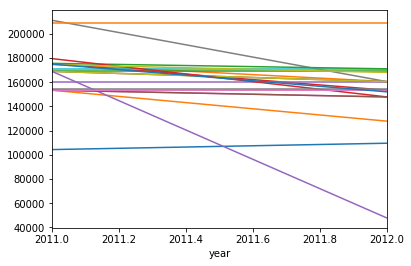

In [89]:
fig , ax = plt.subplots()
df.groupby("estado").plot(x="year",y="maxPrecio", ax=ax,legend = False)

In [ ]:
profecoDf = spark.read.format("csv")\
        .option("delimiter", "|")\
        .option("header","true")\
        .option("inferSchema", "true")\
        .load("profeco_final_bash.csv")